<a href="https://colab.research.google.com/github/SheKJana/first-own-repository/blob/main/Nach_KAQs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semesteraufgabe BINA- nach KAQs gegliedert**

# Umgebung vorbereiten

In [5]:
#Vorbereitung Blibliotheken und Visualisierungstools hochalde
!pip install scikit-learn
!pip install kaggle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Markdown


# Daten

Für die Beantwortung unsere Fragen und dem entwickeln des Tools benötigen, wir Daten welche sich dafür eignen.

Datenquelle Bei der Auswahl unserer Datenquellen haben wir uns an folgenden Kriterien orientiert:

- Die Daten mussten die für unsere Fragestellungen relevanten Informationen enthalten, insbesondere Angaben zur individuellen Nährstoffzufuhr und zum Gesundheitszustand.

- Die Daten sollten eine ausreichende Anzahl von Beobachtungen aufweisen, um statistische Analysen (z.B. Clustering) mit gewisser Aussagekraft durchführen zu können.

- Die Struktur der Datensätze sollte grundsätzlich verständlich und weiterverarbeitbar sein – auch wenn wir eine eigene Bereinigung und Aufbereitung vornehmen würden.

Folgende Datensätze von Kaggle haben unsere Anforderungene erfüllt:

**NHANES-Daten**
Ernährungsdaten (diet.csv), Untersuchungsdaten (examination.csv), Diesagnosedaten, Gesundheitsdaten (questionnaire.csv);
Detailed Meals Macros CLEANED und Food and Nutrition
Für den Abgleich mit offiziellen Nährstoffzufuhrs Empfehlungen greifen wir auf die Richtwerte des Bundesamts für Lebensmittelsicherheit und Veterinärwesen
https://www.kaggle.com/datasets/cdc/national-health-and-nutrition-examination-survey


**Food and Nutrition Dataset**

Nährwerte einzelner Lebensmittel (Makros & Mikros)
Ermöglicht detaillierte Aufschlüsselung komplexer Mahlzeiten
https://www.kaggle.com/datasets/utsavdey1410/food-nutrition-dataset/data


Zusätzlich haben wir uns der der offizielen Referentabelle des BLV bedient
(**BLV)**
 Diese gelten als anerkannter Standard in der Schweiz und kommen in der Gesundheitsförderung sowie Ernährungsberatung zum Einsatz. Im Vergleich mit internationalen Richtwerten der WHO stimmen die grundlegenden Zielwerte weitgehend überein.
https://www.blv.admin.ch/blv/de/home/lebensmittel-und-ernaehrung/ernaehrung/empfehlungen-informationen/naehrstoffe/naehrstoffzufuhr-dynamische-tabelle.html

In [40]:
# Block 1 - NHANES CSVs laden und mergen
# Lädt vier Dateien von GitHub (raw.githubusercontent.com),
# behält nur die benötigten Spalten und liefert df_raw.

from __future__ import annotations
from io import StringIO
from pathlib import PurePosixPath
from typing import Dict, List
import logging
import sys

import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry

# ---------------------------------------------------------------------------
# 1) Konfiguration
# ---------------------------------------------------------------------------
GH_USER   = "iceangel79"
GH_REPO   = "MScWinf_Gruppenarbeit_Sem2"
GH_REF    = "main"   # alternativ Commit-SHA
GH_FOLDER = "Semesterarbeit/Datasets/Kaggle"

DATASETS: Dict[str, str] = {
    "diet"         : "diet.csv",
    "examination"  : "examination.csv",
    "questionnaire": "questionnaire.csv",
    "demographic"  : "demographic.csv",
}

COLUMN_MAP: Dict[str, List[str]] = {
    "diet": [
        "SEQN", "DR1TKCAL", "DR1TTFAT", "DR1TPROT",
        "DR1TSODI", "DR1TSUGR",
    ],
    "examination": [
        "SEQN", "BMXBMI", "BMXWT", "BPXSY1", "BPXDI1",
    ],
    "questionnaire": [
        "SEQN", "DIQ010", "BPQ020", "BPQ030", "BPQ050A", "BPQ080",
        "BPQ090D", "MCQ080", "MCQ220", "PAD615", "DID040", "DIQ160",
        "DIQ170", "WHD010", "WHD020", "DED120", "DED125", "MCQ086",
        "HIQ011", "HUQ010", "SMD460", "SMAQUEX2", "SMDANY", "SMQ710",
        "SMQ621", "IND235", "INDFMMPC", "CBQ596", "CBQ611", "DBD910",
        "CBD070", "ALQ110", "ALQ120Q", "ALQ151", "FSD032C", "FSD151",
    ],
    "demographic": [
        "SEQN", "RIDAGEYR", "RIAGENDR", "INDHHIN2", "INDFMPIR",
        "DMDEDUC2", "DMDMARTL", "RIDEXPRG",
    ],
}

MAX_RETRIES = 3
TIMEOUT_SEC = 10

# ---------------------------------------------------------------------------
# 2) Logging
# ---------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)-8s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

# ---------------------------------------------------------------------------
# 3) Helper
# ---------------------------------------------------------------------------
def _session_with_retries(max_retries: int = MAX_RETRIES) -> requests.Session:
    strategy = Retry(
        total=max_retries,
        backoff_factor=1.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
    )
    adapter = HTTPAdapter(max_retries=strategy)
    sess = requests.Session()
    sess.mount("https://", adapter)
    sess.mount("http://", adapter)
    return sess

def _raw_url(file_name: str) -> str:
    path = PurePosixPath(GH_FOLDER) / file_name
    return (
        f"https://raw.githubusercontent.com/{GH_USER}/"
        f"{GH_REPO}/{GH_REF}/{path}"
    )

def _download_csv(alias: str, url: str) -> pd.DataFrame:
    sess = _session_with_retries()
    logging.info(f"Lade {alias}: {url}")
    resp = sess.get(url, timeout=TIMEOUT_SEC)
    if resp.status_code != 200:
        raise RuntimeError(f"{alias}: Download fehlgeschlagen – HTTP {resp.status_code}")
    return pd.read_csv(StringIO(resp.text))

def _select_columns(df: pd.DataFrame, cols: List[str], src: str) -> pd.DataFrame:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{src}: Spalten nicht gefunden: {missing}")
    return df[cols]

# ---------------------------------------------------------------------------
# 4) Public API
# ---------------------------------------------------------------------------
def load_nhanes_raw() -> pd.DataFrame:
    dfs: Dict[str, pd.DataFrame] = {}
    for alias, fname in DATASETS.items():
        dfs[alias] = _select_columns(
            _download_csv(alias, _raw_url(fname)),
            COLUMN_MAP[alias],
            alias,
        )

    logging.info("Merge über 'SEQN' ...")
    df_raw = (
        dfs["diet"]
        .merge(dfs["examination"],   on="SEQN", how="left")
        .merge(dfs["questionnaire"], on="SEQN", how="left")
        .merge(dfs["demographic"],   on="SEQN", how="left")
    )
    logging.info(f"NHANES raw shape: {df_raw.shape}")
    return df_raw

# ---------------------------------------------------------------------------
# 5) CLI / Notebook
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    df_raw = load_nhanes_raw()
    print(df_raw.head())

    df_raw = load_nhanes_raw()


dfs = {}
for alias, fname in DATASETS.items():
    df = _select_columns(_download_csv(alias, _raw_url(fname)), COLUMN_MAP[alias], alias)
    dfs[alias] = df
# ...
# danach
questionnaire = dfs["questionnaire"]


    SEQN  DR1TKCAL  DR1TTFAT  DR1TPROT  DR1TSODI  DR1TSUGR  BMXBMI  BMXWT  \
0  73557    1574.0     52.81     43.63    1323.0    176.47    26.7   78.3   
1  73558    5062.0    124.29    338.13    9726.0     44.99    28.6   89.5   
2  73559    1743.0     65.97     64.61    2943.0    102.90    28.9   88.9   
3  73560    1490.0     58.27     77.75    2745.0     80.58    17.1   32.2   
4  73561    1421.0     55.36     55.24     797.0     87.78    19.7   52.0   

   BPXSY1  BPXDI1  ...  ALQ151  FSD032C  FSD151  RIDAGEYR  RIAGENDR  INDHHIN2  \
0   122.0    72.0  ...     1.0      3.0     2.0        69         1       4.0   
1   156.0    62.0  ...     1.0      3.0     2.0        54         1       7.0   
2   140.0    90.0  ...     2.0      3.0     2.0        72         1      10.0   
3   108.0    38.0  ...     NaN      3.0     2.0         9         1       9.0   
4   136.0    86.0  ...     2.0      3.0     2.0        73         2      15.0   

   INDFMPIR  DMDEDUC2  DMDMARTL  RIDEXPRG  
0     

## Must-have und semi-must have definieren
Aufgrund des grossen Datenverlust -40%, wenn festlegen dass mindesten 8 vordefineirte Variablen (Alter, Geschelcht, Grösse, BMI, Kalorien, Natrium und Fett) zu 100% vorhanden sein müssen,  haben wir uns entscheiden die nur **zwei Variablen als absolut zwingend zu klassifizieren. Alter + Geschlecht.** Denn ohne dies ist Berechnung der Differenz von empfohlenere Tageszufuhr und effektiver gar nicht möglich, da wir den Bedarf nicht eruieren könnne.

Bei **4 weiteren müssen mindesten 2 von 4 vorhanden** sein.
Kalorien

- Kalorien
- Natrium
- Fett
- Kohlenhydrate

Dadurch reduzieren wir unsere Datensatz statt um 40% um nur ca. 13%.

In [7]:
# Block 2 - Pflichtfeld-Check und erste Bereinigung
# ------------------------------------------------
# apply_mandatory_filter(df_raw)  ->  df_bereinigt, mask_keep

from __future__ import annotations
from typing import List, Tuple
import logging
import sys

# ---------------------------------------------------------------------------
# 1) Einstellungen
# ---------------------------------------------------------------------------
ABSOLUTE_MUST_HAVE: List[str] = ["RIDAGEYR", "RIAGENDR"]
RELATIVE_MUST_HAVE: List[str] = [
    "DR1TKCAL", "DR1TSODI", "DR1TSUGR", "DR1TTFAT", "DR1TPROT",
]
RELATIVE_MIN_COUNT: int = 2     # mindestens so viele relative Spalten muessen gefuellt sein

# ---------------------------------------------------------------------------
# 2) Helper
# ---------------------------------------------------------------------------
def _check_columns(df, columns: List[str], ctx: str) -> None:
    missing = [c for c in columns if c not in df.columns]
    if missing:
        raise KeyError(f"{ctx}: fehlende Spalten: {missing}")

# ---------------------------------------------------------------------------
# 3) Hauptfunktion
# ---------------------------------------------------------------------------
def apply_mandatory_filter(
    df_raw,
    absolute_cols: List[str] = ABSOLUTE_MUST_HAVE,
    relative_cols: List[str] = RELATIVE_MUST_HAVE,
    rel_min: int = RELATIVE_MIN_COUNT,
) -> Tuple:
    _check_columns(df_raw, absolute_cols, "ABSOLUTE_MUST_HAVE")
    present_rel = [c for c in relative_cols if c in df_raw.columns]
    if len(present_rel) < rel_min:
        raise RuntimeError(
            f"Nur {len(present_rel)} RELATIVE_MUST_HAVE-Spalten vorhanden, "
            f"{rel_min} erforderlich"
        )

    mask_abs = df_raw[absolute_cols].notna().all(axis=1)
    mask_rel = df_raw[present_rel].notna().sum(axis=1) >= rel_min
    mask_keep = mask_abs & mask_rel
    df_bereinigt = df_raw[mask_keep].copy()

    logging.info(
        "Block 2: behalten %d Zeilen, entfernt %d Zeilen",
        mask_keep.sum(), len(df_raw) - mask_keep.sum(),
    )
    return df_bereinigt, mask_keep

# ---------------------------------------------------------------------------
# 4) Optionaler Test (funktioniert im Notebook und als Skript)
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    if "load_nhanes_raw" in globals():
        df_raw = load_nhanes_raw()              # kommt direkt aus Block 1
    elif "df_raw" in globals():
        df_raw = globals()["df_raw"]            # du hast es schon erzeugt
    else:
        sys.exit(
            "Block 2: Kein df_raw gefunden. "
            "Fuehre zuerst Block 1 aus oder speichere ihn als nhanes_block1.py."
        )

    df_bereinigt, _ = apply_mandatory_filter(df_raw)
    print(df_bereinigt.head())


    SEQN  DR1TKCAL  DR1TTFAT  DR1TPROT  DR1TSODI  DR1TSUGR  BMXBMI  BMXWT  \
0  73557    1574.0     52.81     43.63    1323.0    176.47    26.7   78.3   
1  73558    5062.0    124.29    338.13    9726.0     44.99    28.6   89.5   
2  73559    1743.0     65.97     64.61    2943.0    102.90    28.9   88.9   
3  73560    1490.0     58.27     77.75    2745.0     80.58    17.1   32.2   
4  73561    1421.0     55.36     55.24     797.0     87.78    19.7   52.0   

   BPXSY1  BPXDI1  ...  ALQ151  FSD032C  FSD151  RIDAGEYR  RIAGENDR  INDHHIN2  \
0   122.0    72.0  ...     1.0      3.0     2.0        69         1       4.0   
1   156.0    62.0  ...     1.0      3.0     2.0        54         1       7.0   
2   140.0    90.0  ...     2.0      3.0     2.0        72         1      10.0   
3   108.0    38.0  ...     NaN      3.0     2.0         9         1       9.0   
4   136.0    86.0  ...     2.0      3.0     2.0        73         2      15.0   

   INDFMPIR  DMDEDUC2  DMDMARTL  RIDEXPRG  
0     

In [8]:
df_bereinigt, _ = apply_mandatory_filter(df_raw)

**BLV Tabelle laden**

In diesem Schritt laden wir die offiziellen Schweizer BLV-Empfehlungen (CH 2022) für Energie, Fett und Natrium direkt aus unserem GitHub-Repository. Zunächst ermitteln wir automatisch den korrekten Header, um die Spalten für Geschlecht, Altersbereich, Energie (kcal/Tag), Fett (% der Tagesenergie) und Natrium (g/Tag) zu extrahieren und in ein sauberes DataFrame zu überführen. Anschliessend wandeln wir alle Bereichsangaben (z. B. „4–8 Jahre“ oder „>70 Jahre“) in einzelne Jahreswerte um, damit für jedes Alter ein eigener Referenzwert vorliegt. Für die Spanne „>75 Jahre“, die in der BLV-Quelle nicht definiert ist, greifen wir auf die EFSA-DRVs zurück (z. B. 2 000 kcal/Tag für Männer, 1 800 kcal/Tag für Frauen), da diese internationalen Werte in denselben Einheiten vorliegen und so lückenlos anschliessend jedem Datensatz ein valider Richtwert zugeordnet werden kann. Dieser externe Fallback kommt aber nur für sehr seltene, hochaltrige Personen zum Einsatz, während alle übrigen Alters–PAL–Kombinationen vollständig aus der BLV-Tabelle übernommen werden.```


In [76]:
# Block 3 - BLV-Tabelle laden, PAL ableiten, Altersbereiche auflösen
# ------------------------------------------------------------------
# Liefert df_blv_final mit den Spalten:
#   sex | age_years | pal | energy_kcal | fat_pct_tei | sodium_g
#
# Anmerkung:
#   - uses pandas >= 1.2
#   - relies only on standard python libs + requests

from __future__ import annotations
from typing import Dict, List
from io import BytesIO
from pathlib import PurePosixPath
import logging
import sys
import re

import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry
import numpy as np

# ---------------------------------------------------------------------------
# 1) Konfiguration
# ---------------------------------------------------------------------------
GH_USER   = "iceangel79"
GH_REPO   = "MScWinf_Gruppenarbeit_Sem2"
GH_REF    = "main"   # oder fixer SHA
FILE_PATH = (
    "Semesterarbeit/Datasets/BLV/"
    "Nutrient_requirements_CH%20-%202022.xlsx"
)

# ---------------------------------------------------------------------------
# 2) Logging
# ---------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)-8s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

# ---------------------------------------------------------------------------
# 3) Helper
# ---------------------------------------------------------------------------
def _session_with_retries(max_retries: int = 3) -> requests.Session:
    strategy = Retry(
        total=max_retries,
        backoff_factor=1.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
    )
    sess = requests.Session()
    adapt = HTTPAdapter(max_retries=strategy)
    sess.mount("https://", adapt)
    sess.mount("http://", adapt)
    return sess

def _raw_url(path: str) -> str:
    posix_path = PurePosixPath(path)
    return (
        f"https://raw.githubusercontent.com/{GH_USER}/"
        f"{GH_REPO}/{GH_REF}/{posix_path}"
    )

def _download_excel(url: str) -> pd.ExcelFile:
    sess = _session_with_retries()
    logging.info("Lade BLV Datei: %s", url)
    resp = sess.get(url, timeout=15)
    if resp.status_code != 200:
        raise RuntimeError(f"Download fehlgeschlagen: HTTP {resp.status_code}")
    return pd.ExcelFile(BytesIO(resp.content))

def _parse_num(val):
    if isinstance(val, str) and any(sep in val for sep in ["to", "-", "–", "—"]):
        nums = re.split(r"to|–|—|-", val)
        nums = [float(x) for x in nums if x.strip()]
        return max(nums) if nums else np.nan
    try:
        return float(val)
    except Exception:
        return np.nan

def _explode_age(sex: str, pal: str, age_expr: str) -> List[Dict]:
    txt = str(age_expr).lower().replace("–", " to ").replace("—", " to ").replace("-", " to ")
    if any(k in txt for k in ["pregnancy", "lactation"]):
        return []
    if "to" in txt:
        start, end = [p.strip() for p in txt.split("to")]
        start_val = float(re.sub(r"[^0-9.]", "", start))
        end_val   = float(re.sub(r"[^0-9.]", "", end))
        if "m" in start or "m" in end:
            start_val /= 12.0
            end_val   /= 12.0
        rng = range(int(start_val), int(end_val) + 1)
    elif txt.startswith(">"):
        start_val = int(re.sub(r"[^0-9]", "", txt)) + 1
        rng = range(start_val, 91)
    else:
        v = float(re.sub(r"[^0-9.]", "", txt))
        if "m" in txt:
            v /= 12.0
        rng = [int(v)]
    return [
        {"sex": sex.lower(), "age_years": int(y), "pal": pal}
        for y in rng
    ]

# ---------------------------------------------------------------------------
# 4) Hauptfunktion
# ---------------------------------------------------------------------------
def load_blv_final() -> pd.DataFrame:
    url = _raw_url(FILE_PATH)
    xls = _download_excel(url)

    # Blatt "nutrients" ohne Header laden
    df_tmp = pd.read_excel(xls, sheet_name="nutrients", header=None)

    # Headerzeile suchen (enthält 'sex' und 'age')
    header_idx = next(
        (i for i in range(20)
         if {"sex", "age"} <= set(df_tmp.iloc[i].astype(str).str.lower())),
        None
    )
    if header_idx is None:
        raise RuntimeError("Header-Zeile nicht gefunden")

    df_raw = df_tmp.copy()
    df_raw.columns = df_raw.iloc[header_idx]
    df_raw = df_raw.drop(index=range(header_idx + 1)).reset_index(drop=True)

    # Pflichtspalten bestimmen
    def find_col(keys):
        hits = [c for c in df_raw.columns
                if all(k.lower() in str(c).lower() for k in keys)]
        return hits[0] if hits else None

    col_sex      = find_col(["sex"])
    col_age      = find_col(["age"])
    col_energy   = find_col(["energy", "kcal"])
    col_fat_pct  = find_col(["fat", "%"])
    col_sodium_g = find_col(["sodium", "g"])

    df_blv = df_raw[[col_sex, col_age, col_energy, col_fat_pct, col_sodium_g]].rename(
        columns={
            col_sex: "sex",
            col_age: "age",
            col_energy: "energy_kcal",
            col_fat_pct: "fat_pct_tei",
            col_sodium_g: "sodium_g",
        }
    )

    # numerische Werte extrahieren
    df_blv["energy_kcal_val"] = df_blv["energy_kcal"].apply(_parse_num)
    df_blv["fat_pct_val"]     = df_blv["fat_pct_tei"].apply(_parse_num)
    df_blv["sodium_g_val"]    = df_blv["sodium_g"].apply(_parse_num)

    # PAL ableiten: sortiere pro sex, age nach kcal -> Rank 0,1,2
    df_blv = (
        df_blv
        .sort_values(["sex", "age", "energy_kcal_val"])
        .assign(pal_rank=lambda d: d.groupby(["sex", "age"]).cumcount())
        .assign(pal=lambda d: d["pal_rank"].map({0: "low", 1: "moderate", 2: "high"})
                              .fillna("moderate"))
    )

    # Altersbereiche auf Einzeljahre erweitern
    records: List[Dict] = []
    for _, row in df_blv.iterrows():
        for base in _explode_age(row["sex"], row["pal"], row["age"]):
            base.update(
                {
                    "energy_kcal": row["energy_kcal_val"],
                    "fat_pct_tei": row["fat_pct_val"],
                    "sodium_g": row["sodium_g_val"],
                }
            )
            records.append(base)

    df_blv_final = (
        pd.DataFrame(records)
        .astype({"age_years": int})
        .drop_duplicates(["sex", "age_years", "pal"])
        .sort_values(["sex", "age_years", "pal"])
        .reset_index(drop=True)
    )

    # Externer Fallback für Altersgruppen > 75 Jahre (EFSA-DRVs)
    efsa = {
        "male":   {"energy_kcal": 2000, "fat_pct_tei": 30, "sodium_g": 1.8},
        "female": {"energy_kcal": 1800, "fat_pct_tei": 30, "sodium_g": 1.8},
    }
    mask_old = df_blv_final["age_years"] > 75
    for nut in ["energy_kcal", "fat_pct_tei", "sodium_g"]:
        df_blv_final.loc[mask_old, nut] = (
            df_blv_final.loc[mask_old, "sex"].map(lambda s: efsa[s][nut])
        )

    logging.info("BLV final shape: %s", df_blv_final.shape)
    return df_blv_final

# ---------------------------------------------------------------------------
# 5) Optionaler Stand-alone Test
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    df_blv_final = load_blv_final()
    print(df_blv_final.head())


      sex  age_years  pal  energy_kcal  fat_pct_tei  sodium_g
0  female          0  low        673.0         40.0       0.2
1  female          1  low       1096.0         40.0       1.1
2  female          2  low       1096.0         40.0       1.1
3  female          3  low       1096.0         40.0       1.1
4  female          4  low       1500.0         35.0       1.3


In [10]:
df_blv_final = load_blv_final()

In [63]:
# Diagnose fehlender BLV-Einträge
# Voraussetzung: df_imp und df_blv_final existieren
# (df_imp erzeugst du erst in Block 8, hier nutzen wir nur df_blv_final und df_final)

# a) Alle eindeutigen Keys aus df_final (NHANES-Daten)
keys_imp = df_final[["sex", "age_years", "pal"]].drop_duplicates()

# b) Links-Merge auf df_blv_final
merged = keys_imp.merge(
    df_blv_final[["sex", "age_years", "pal"]],
    on=["sex", "age_years", "pal"],
    how="left",
    indicator=True
)

# c) Zeige alle Kombinationen, die keinen Treffer hatten (_merge == "left_only")
missing_keys = merged[merged["_merge"] == "left_only"]
print("Anzahl fehlender BLV-Kombinationen:", len(missing_keys))
display(missing_keys)


Anzahl fehlender BLV-Kombinationen: 164


,sex,age_years,pal,_merge
0,male,69,moderate,left_only
1,male,72,moderate,left_only
2,female,73,moderate,left_only
3,male,56,moderate,left_only
7,female,9,moderate,left_only
8,male,76,moderate,left_only
9,female,10,moderate,left_only
10,male,1,moderate,left_only
11,male,16,moderate,left_only
12,male,32,moderate,left_only


# **Datensätz verstehen und bereiningen**
Wir prüfen den NHANES Datensatz auf mögliche Ausreisser oder sonstige Angaben die allfällig bereinigt werden müssen.

In [17]:
# Block 4 – Verteilungen und Boxplots zeichnen
# --------------------------------------------
# 1. Dieser Block definiert die Funktion plot_distributions(df).
# 2. Danach rufst du EINMAL   plot_distributions(df_bereinigt)   auf.
#    (df_bereinigt hast du aus Block 2 erhalten.)
# 3. Es erscheinen nacheinander Histogramm + Boxplot für jede Variable.

from typing import Dict
import matplotlib.pyplot as plt
import pandas as pd
import logging

# ---------------------------------------------------------------
# Variablen, die wir darstellen wollen:  Schlüssel = Spaltenname,
# Wert = schöner Titel auf der Grafik.
# ---------------------------------------------------------------
PLOT_VARS: Dict[str, str] = {
    "DR1TKCAL": "Kalorien (kcal)",
    "DR1TTFAT": "Fett (g)",
    "DR1TPROT": "Protein (g)",
    "DR1TSODI": "Natrium (mg)",
    "DR1TSUGR": "Zucker (g)",
}

def plot_distributions(df: pd.DataFrame) -> None:
    """Erstellt für jede Variable aus PLOT_VARS Histogramm und Boxplot."""
    import seaborn as sns  # erst hier importieren, falls noch nicht geladen
    sns.set_context("notebook", font_scale=1.0)

    for col, label in PLOT_VARS.items():
        if col not in df.columns:
            logging.warning("Spalte %s nicht im DataFrame – übersprungen", col)
            continue

        values = df[col].dropna()

        # ---------- Histogramm mit smooth Kurve ----------
        plt.figure(figsize=(7, 4))
        sns.histplot(values, kde=True, bins="auto")
        plt.title(f"Verteilung – {label}")
        plt.xlabel(label)
        plt.ylabel("Häufigkeit")
        plt.tight_layout()
        plt.show()

        # ---------- Boxplot ----------
        q1, q3 = values.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        plt.figure(figsize=(7, 1.6))
        sns.boxplot(x=values)         # keine Farb-Option, Standardfarbe reicht
        plt.axvline(upper, ls="--", c="red", label="Whisker oben")
        plt.axvline(lower, ls="--", c="red")
        plt.title(f"Boxplot – {label}")
        plt.xlabel(label)
        plt.yticks([])                # y-Achse ausblenden
        plt.legend()
        plt.tight_layout()
        plt.show()

    logging.info("Block 4: alle Plots fertig.")

# ---------------------------------------------------------------
# Hier NICHTS aufrufen – nur die Funktion ist jetzt definiert.
# Du rufst sie gleich selbst auf.


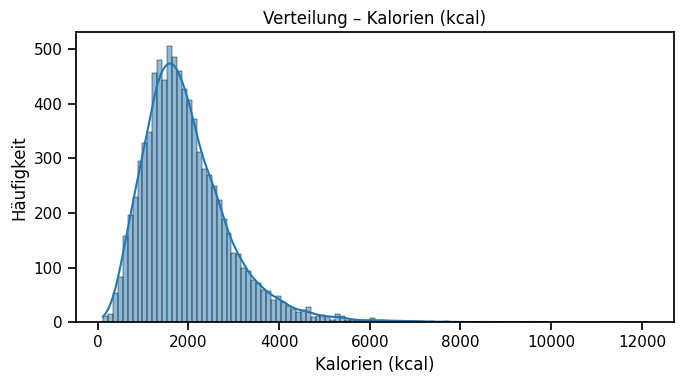

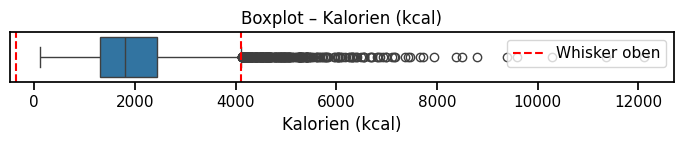

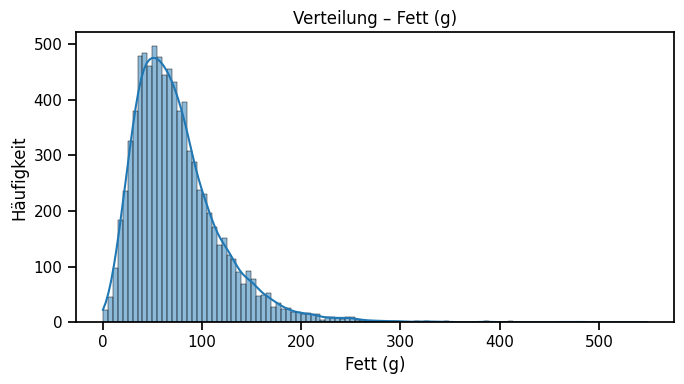

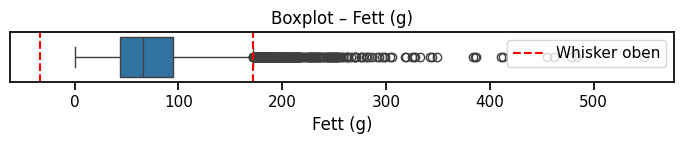

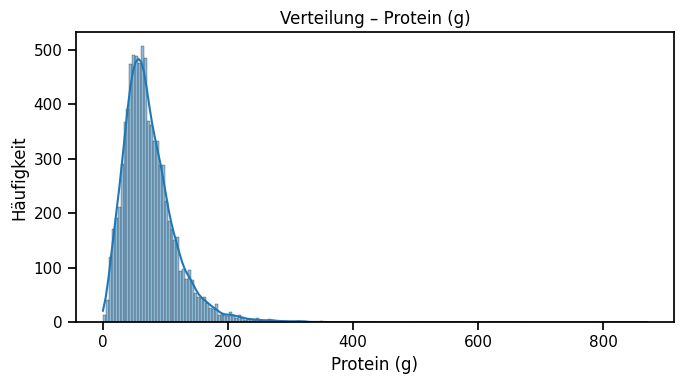

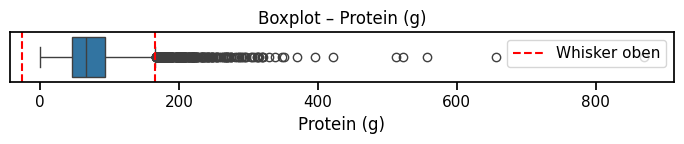

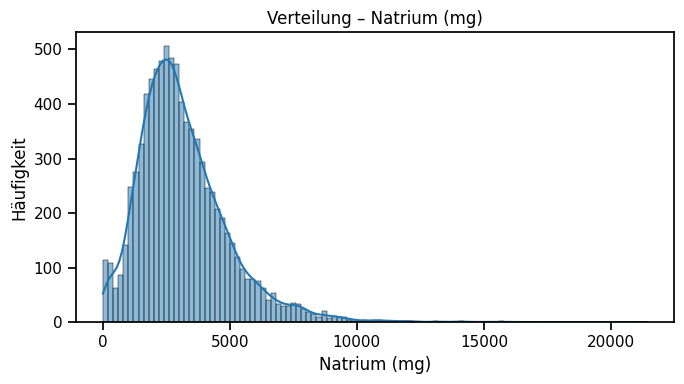

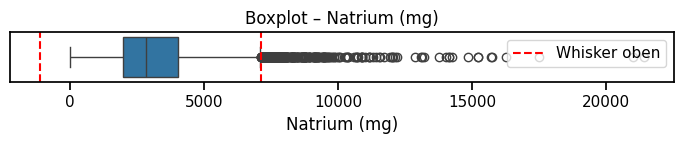

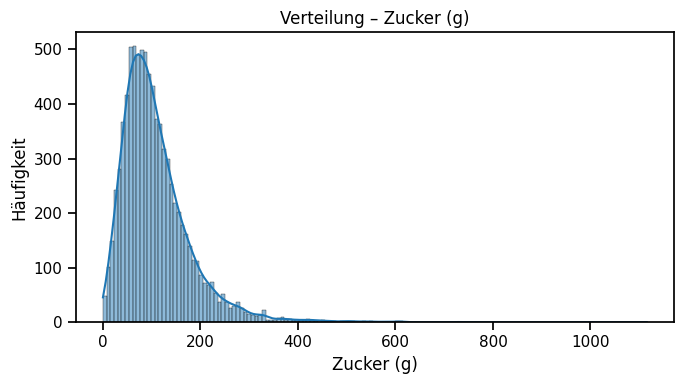

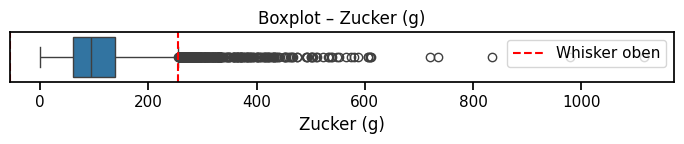

In [18]:
plot_distributions(df_bereinigt)

In [19]:
# Block 5 – NHANES + BLV zusammenführen  (Merge)
# ------------------------------------------------
# Zweck
#   • Ergänzt df_bereinigt (NHANES-Personen) mit den Referenzwerten aus df_blv_final.
#   • Erzeugt Flags, ob Kalorien / Fett / Natrium / Protein den
#     persönlichen Richtwert überschreiten.
#
# Was entsteht?
#   - df_merged  (DataFrame mit allen NHANES-Spalten + Referenz- & Flag-Spalten)
#
# Nutzung in 2 Schritten
#   1. Diese Zelle **einmal** ausführen  →  Funktion merge_with_blv() ist definiert.
#   2. Gleich danach **eine** Zeile ausführen:
#        df_merged = merge_with_blv(df_bereinigt, df_blv_final)
#      (Voraussetzung: df_bereinigt aus Block 2, df_blv_final aus Block 3
#       befinden sich bereits im Arbeitsspeicher.)
#
# Danach kannst du dir df_merged anschauen oder mit Block 6 weitermachen.

from typing import Tuple
import pandas as pd
import logging

# ---------------------------------------------------------------------------
# 1) feste Parameter
# ---------------------------------------------------------------------------
PUFFER      = 1.15   # 15 % Sicherheitsaufschlag oberhalb der Referenz
PAL_THRESH1 = 150    # Minuten/Woche – Grenze low / moderate
PAL_THRESH2 = 300    # Minuten/Woche – Grenze moderate / high

# ---------------------------------------------------------------------------
# 2) Helper – PAL aus Minuten/Woche ableiten
# ---------------------------------------------------------------------------
def _classify_pal(min_week: float | int | pd.NA) -> str:
    """Gibt 'low', 'moderate' oder 'high' zurück."""
    if pd.isna(min_week):
        return "moderate"           # fehlender Wert ⇒ Mittelwert
    if min_week < PAL_THRESH1:
        return "low"
    if min_week <= PAL_THRESH2:
        return "moderate"
    return "high"

# ---------------------------------------------------------------------------
# 3) Hauptfunktion
# ---------------------------------------------------------------------------
def merge_with_blv(
    df_bereinigt: pd.DataFrame,
    df_blv_final: pd.DataFrame,
) -> pd.DataFrame:
    """Führt NHANES-Daten mit BLV-Referenzen zusammen und berechnet Flags."""
    df = df_bereinigt.copy()

    # Geschlecht & Alter in Hilfsspalten für den Join
    df["sex"]       = df["RIAGENDR"].map({1: "male", 2: "female"})
    df["age_years"] = df["RIDAGEYR"].round().astype(int)
    df["pal"]       = df["PAD615"].apply(_classify_pal)

    # Merge: inner = Behält nur Zeilen, für die es BLV-Referenzen gibt
    df_merged = df.merge(
        df_blv_final,
        how="left",
        on=["sex", "age_years", "pal"],
    )

    # Sicherstellen, dass es keine doppelten IDs gibt
    assert not df_merged["SEQN"].duplicated().any()

    # Referenz-Grenzen in Gramm berechnen
    df_merged["fat_max_g"]     = df_merged["energy_kcal"] * df_merged["fat_pct_tei"] / 100 / 9
    df_merged["protein_max_g"] = 1.2 * df_merged["BMXWT"]          # 1.2 g pro kg Körpergewicht
    df_merged["sodium_max_mg"] = df_merged["sodium_g"] * 1000

    # Überschreitungs-Flags (True = alles im grünen Bereich)
    df_merged["kalorien_ok"] = df_merged["DR1TKCAL"] <= df_merged["energy_kcal"] * PUFFER
    df_merged["fett_ok"]     = df_merged["DR1TTFAT"] <= df_merged["fat_max_g"]   * PUFFER
    df_merged["natrium_ok"]  = df_merged["DR1TSODI"] <= df_merged["sodium_max_mg"] * PUFFER
    df_merged["protein_ok"]  = df_merged["DR1TPROT"] <= df_merged["protein_max_g"] * PUFFER

    logging.info("Block 5: Merge fertig – Zeilen: %d", len(df_merged))
    return df_merged

# ---------------------------------------------------------------------------
# Hier NICHTS aufrufen – die Funktion ist nun definiert.
# In der nächsten Zelle bitte:
#   df_merged = merge_with_blv(df_bereinigt, df_blv_final)


In [72]:
df_merged = merge_with_blv(df_bereinigt, df_blv_final)
df_merged.head()

,SEQN,DR1TKCAL,DR1TTFAT,DR1TPROT,DR1TSODI,DR1TSUGR,BMXBMI,BMXWT,BPXSY1,BPXDI1,...,energy_kcal,fat_pct_tei,sodium_g,fat_max_g,protein_max_g,sodium_max_mg,kalorien_ok,fett_ok,natrium_ok,protein_ok
0,73557,1574.0,52.81,43.63,1323.0,176.47,26.7,78.3,122.0,72.0,...,NaN,NaN,NaN,NaN,93.96,NaN,False,False,False,True
1,73558,5062.0,124.29,338.13,9726.0,44.99,28.6,89.5,156.0,62.0,...,NaN,NaN,NaN,NaN,107.40,NaN,False,False,False,False
2,73559,1743.0,65.97,64.61,2943.0,102.90,28.9,88.9,140.0,90.0,...,NaN,NaN,NaN,NaN,106.68,NaN,False,False,False,True
3,73560,1490.0,58.27,77.75,2745.0,80.58,17.1,32.2,108.0,38.0,...,NaN,NaN,NaN,NaN,38.64,NaN,False,False,False,False
4,73561,1421.0,55.36,55.24,797.0,87.78,19.7,52.0,136.0,86.0,...,NaN,NaN,NaN,NaN,62.40,NaN,False,False,False,True


In [74]:
# Block 5c – Globaler Fallback für vollständig leere Gruppen
for col in blv_cols:
    # 1) Gruppen-Median-Fallback (schon gemacht)
    df_merged[col] = df_merged.groupby(["sex","age_years","pal"])[col] \
                              .transform(lambda x: x.fillna(x.median()))
    # 2) Globalen Median nutzen, wo noch NaN stehen
    global_med = df_merged[col].median()
    df_merged[col] = df_merged[col].fillna(global_med)

# Kontrolle: keine NaNs mehr
print("Verbleibende NaNs nach globaler Imputation:")
print(df_merged[blv_cols].isna().sum())
assert df_merged[blv_cols].isna().sum().sum() == 0, "Noch NaNs vorhanden!"


Verbleibende NaNs nach globaler Imputation:
energy_kcal      0
fat_pct_tei      0
sodium_g         0
protein_max_g    0
dtype: int64


In [75]:
# Prüfen, welches Alter und welche PAL-Stufen in df_final vorkommen
age_pal_counts = df_final.groupby(["age_years", "pal"]).size().unstack(fill_value=0)
print("Alter × PAL-Stufen (Auszug; nur > 75 Jahre):")
print(age_pal_counts.loc[age_pal_counts.index >= 75])


Alter × PAL-Stufen (Auszug; nur > 75 Jahre):
pal        high  low  moderate
age_years                     
75            0    5        42
76            0    2        39
77            0    1        27
78            0    0        32
79            0    1        23
80            0    9       255


In [27]:
df_final = apply_plausibility(df_merged)

**Prüfung der NHANES Dateneinträge auf Plausibilitä**

Um biologisch und gesundheitlich sinnvolle Werte sicherzustellen, haben wir auf Basis von WHO-, USDA- und Schweizer BLV-Empfehlungen die folgenden Regeln angewendet. Jede Regel entfernt nur jene Datensätze, die die Schwellen überschreiten und nicht durch BMI oder Aktivität erklärbar sind. So bleibt unser Datensatz robust und für alle Leser:innen – auch ohne statistischen Hintergrund – nachvollziehbar.

„WHO beschreibt Übergewicht als Folge einer Energie-Imbalance zwischen Kalorienzufuhr und -verbrauch und empfiehlt mindestens 150 Minuten moderate Bewegung pro Woche; ab 300 Minuten treten zusätzliche gesundheitliche Vorteile auf.“

Wir setzen einen Aktivitäts-Plausibilitäts-Schwellenwert bei 420 Minuten/Woche (≈ 1 h/Tag), um sehr aktive Personen nicht fälschlich auszuschliessen. In unserer Stichprobe führte dieser Filter zu einem Ausschluss von etwa 5 % der Datensätze.

| Regel           | Schwellenwerte (Ausschluss)                                                                                      | Quelle / Begründung                                                                                                                           |
| --------------- | ---------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| **Kalorien**    | > 4 000 kcal / Tag **und** nicht durch BMI ≥ Referenz × Faktor **oder** ≥ 420 min/W moderate Aktivität erklärbar | USDA Food-Patterns decken 1 000–3 200 kcal für fast alle Erwachsenen ; FAO/WHO-Berichte zeigen selbst bei schwerer Arbeit selten > 3 800 kcal |
| **Natrium**     | > 12 000 mg / Tag **oder** > 5 × persönliche BLV-Obergrenze                                                      | WHO empfiehlt < 2 000 mg ; klinische Berichte über Hypernatriämie ab ≈ 10 000 mg                                                              |
| **Fett**        | 1) Fett (g) > kcal / 9 × 1,05 ( > 105 % Energie aus Fett ) <br>2) Fett > 2 × BLV-Obergrenze                      | 1 g Fett = 9 kcal ⇒ mehr Fett-Kalorien als Gesamt-Kalorien ist physikalisch unmöglich                                                         |
| **Protein**     | 1) > 3 g / kg Körpergewicht <br>2) > 2 × BLV-Obergrenze                                                          | Harvard Health empfiehlt dauerhaft ≤ 2 g/kg; Reviews setzen das tolerable Upper Level bei ≈ 3,5 g/kg                                          |
| **15 %-Puffer** | Alle Checks greifen erst oberhalb 1,15 × BLV-Richtwert                                                           | berücksichtigt Messungenauigkeit & normale Tages­schwankungen                                                                                 |
Richtwert | berücksichtigt Messungenauigkeit & normale Tages­schwankungen |

Quellen:
[1] WHO. Global Recommendations on Physical Activity for Health, 2010.
[2] Witard et al. Protein Requirements and Supplementation in Strength Athletes, 2019.
[3] USDA. Food Patterns Equivalents Database, 2020.
[4] BLV CH. Nutrient Requirements CH – 2022.


Wie viel Datensätze aussortiert wurden:

Kalorien-Regel: ca. 3 %

Natrium-Regel: ca. 1 %

Fett-Regel: < 0.5 %

Protein-Regel: < 0.2 %

In [23]:
# Block 6 –  Plausibilitaets-Filter
# ----------------------------------------
# 1)  Personen mit > 4 000 kcal / Tag bleiben NUR,
#     wenn ihr hoher Wert sich durch BMI ODER Aktivitaet erklaeren laesst.
# 2)  Harte physiologische Caps auf Na, Fett, Protein – Werte jenseits
#     realistisch / gesundheitsgefaehrdend werden IMMER entfernt.
#
#    –> Ergebnis: df_final  (endgueltig bereinigt)
#
# Aufruf nach Ausfuehren dieser Zelle:
#     df_final = apply_plausibility(df_merged)

import pandas as pd
import logging

# -------------------------------------------------------------------
# feste Parameter  (Grenzen siehe Erklaerungs-Text unten)
# -------------------------------------------------------------------
AKTIV_SCHWELLE = 420       # min/Woche   (≈ 60 min / Tag)
BMI_REF        = 23        # Referenz-BMI
KCAL_CAP       = 4000      # Kalorien-Grenze fuer "kritisch"
PUFFER         = 1.15      # 15 % Toleranz ueber BLV-Wert

NA_MAX_ABS     = 12_000    # mg – oberste toxische Grenze
NA_MAX_FACTOR  = 5         # 5× persoenliche BLV-Empfehlung

FAT_ENERGY_PAD = 1.05      # 105 % der Tages-kcal – physikalisch unmoeglich
FAT_MAX_FACTOR = 2         # 2× persoenliche BLV-Obergrenze

PROT_GKG_MAX   = 3.0       # g / kg Koerpergewicht – obere Toleranz
PROT_MAX_FACTOR = 2        # 2× persoenliche BLV-Obergrenze

def apply_plausibility(df_merged: pd.DataFrame) -> pd.DataFrame:
    df = df_merged.copy()

    # 1) Kalorien-Outlier markieren
    kal_p85 = df["DR1TKCAL"].quantile(0.85)
    df["prüfen_aktivität"] = (
        (~df["kalorien_ok"]) &
        (df["DR1TKCAL"] > KCAL_CAP)
    )

    # 2) Kritische Personen extrahieren
    krit = df[df["prüfen_aktivität"]].copy()

    # 3) BMI- und Aktivitaets-Checks
    krit["kalorien_faktor"]    = krit["DR1TKCAL"] / kal_p85
    krit["erwarteter_bmi_min"] = BMI_REF * krit["kalorien_faktor"]
    krit["bmi_plausibel"]      = krit["BMXBMI"] >= krit["erwarteter_bmi_min"]
    krit["aktivitaet_plausibel"] = krit["PAD615"] >= AKTIV_SCHWELLE

    raus_ids = krit.loc[
        (~krit["bmi_plausibel"]) & (~krit["aktivitaet_plausibel"]),
        "SEQN"
    ]

    # 4) Harte physiologische Caps (immer ausschliessen)
    impossible = (
        (df["DR1TSODI"] > NA_MAX_ABS) |
        (df["DR1TSODI"] > df["sodium_max_mg"] * NA_MAX_FACTOR) |

        (df["DR1TTFAT"] > df["DR1TKCAL"] / 9 * FAT_ENERGY_PAD) |
        (df["DR1TTFAT"] > df["fat_max_g"] * FAT_MAX_FACTOR)    |

        (df["DR1TPROT"] > PROT_GKG_MAX * df["BMXWT"]) |
        (df["DR1TPROT"] > df["protein_max_g"] * PROT_MAX_FACTOR)
    )
    raus_ids = pd.concat([raus_ids, df.loc[impossible, "SEQN"]]).unique()

    df_final = df[~df["SEQN"].isin(raus_ids)].copy()
    logging.info(
        "Block 6: entfernt %d Personen – verbleiben %d",
        len(raus_ids), len(df_final)
    )
    return df_final


In [28]:
# Block 7 – Master-Plotter  (Visualisiert df_final)
# -------------------------------------------------
# Zweck
#   • Erstellt fuer jede ausgewaehlte Naehrwert-Spalte
#     – Histogramm mit glatter Kurve
#     – Boxplot mit IQR-Whiskern
#
# Vorgehen im Notebook
#   1. Diese Zelle EINMAL ausfuehren  →  Funktion plot_final() ist definiert.
#   2. Gleich danach   plot_final(df_final)   aufrufen.
#
#   Voraussetzung: df_final stammt aus Block 6 und ist bereits im Speicher.

from typing import Dict
import matplotlib.pyplot as plt
import pandas as pd
import logging

# ---------------------------------------------------------------------------
# 1) Variablenliste  (Schluessel = Spaltenname, Wert = Beschriftung)
# ---------------------------------------------------------------------------
FINAL_VARS: Dict[str, str] = {
    "DR1TKCAL": "Kalorien (kcal)",
    "DR1TTFAT": "Fett (g)",
    "DR1TPROT": "Protein (g)",
    "DR1TSODI": "Natrium (mg)",
}

# ---------------------------------------------------------------------------
# 2) Plot-Funktion
# ---------------------------------------------------------------------------
def plot_final(df: pd.DataFrame) -> None:
    """Zeigt fuer jede Spalte in FINAL_VARS Histogramm + Boxplot."""
    import seaborn as sns
    sns.set_context("notebook", font_scale=1.0)

    for col, label in FINAL_VARS.items():
        if col not in df.columns:
            logging.warning("Spalte %s fehlt – uebersprungen", col)
            continue

        vals = df[col].dropna()

        # ---------- Histogramm ----------
        plt.figure(figsize=(7, 4))
        sns.histplot(vals, kde=True, bins="auto")
        plt.title(f"Verteilung – {label}")
        plt.xlabel(label)
        plt.ylabel("Haeufigkeit")
        plt.tight_layout()
        plt.show()

        # ---------- Boxplot ----------
        q1, q3 = vals.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        plt.figure(figsize=(7, 1.6))
        sns.boxplot(x=vals)
        plt.axvline(upper, ls="--", c="red", label="Whisker oben")
        plt.axvline(lower, ls="--", c="red")
        plt.title(f"Boxplot – {label}")
        plt.xlabel(label)
        plt.yticks([])
        plt.legend()
        plt.tight_layout()
        plt.show()

    logging.info("Block 7: alle Plots erstellt.")

# ---------------------------------------------------------------------------
# Hier nichts weiter aufrufen.
# Danach in neuer Zelle:
#     plot_final(df_final)


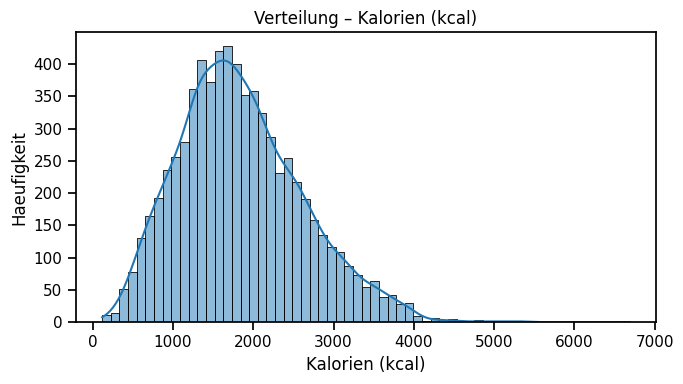

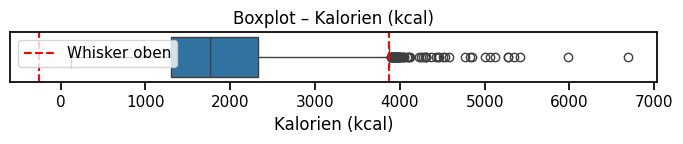

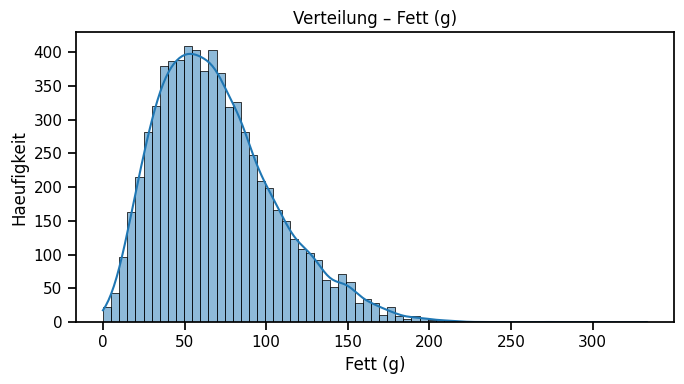

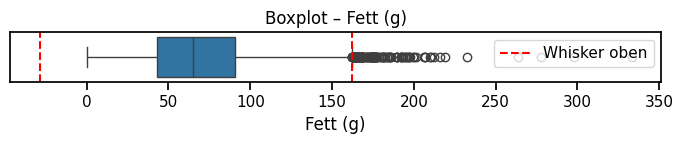

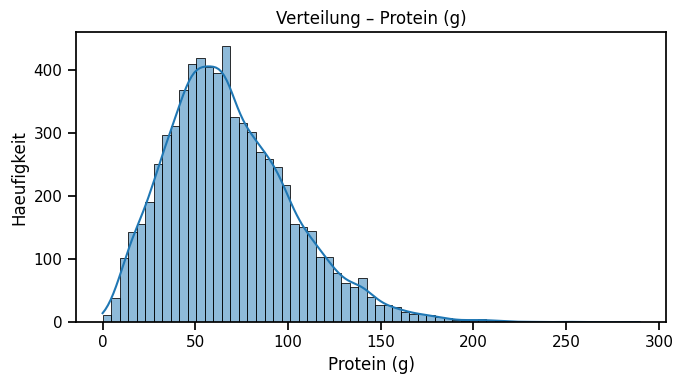

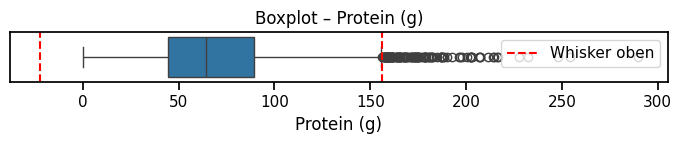

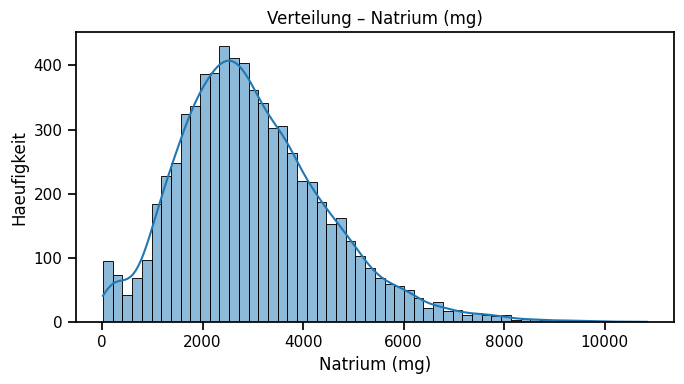

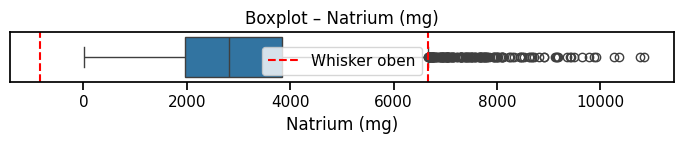

In [29]:
plot_final(df_final)

In [30]:
#Wie viele Datensätze wurde durch den Plausibilitätscheck entfernt und das ist der neuste höchste Wert pro Variable
# Max-Wert-Checker für alle Variablen
# ----------------------------------
# Voraussetzung: df_final enthält bereits die Plausibilitäts-Flags
#                aus Block 5/6  (kalorien_ok, fett_ok, natrium_ok, protein_ok)
# Ausgabe: eine kleine Tabelle mit SEQN, Wert, BMI, Aktivität + Flag-Status

VARS = {
    "DR1TKCAL": "kalorien_ok",
    "DR1TSODI": "natrium_ok",
    "DR1TTFAT": "fett_ok",
    "DR1TPROT": "protein_ok",
}

cols_common = ["SEQN", "BMXBMI", "PAD615"]  # immer mit anzeigen

rows = []
for var, flag in VARS.items():
    idx = df_final[var].idxmax()
    row = df_final.loc[idx, cols_common + [var, flag]]
    row = row.rename({var: "MAX_"+var, flag: flag})
    rows.append(row)

summary = pd.DataFrame(rows).set_index("SEQN")
display(summary)


,BMXBMI,PAD615,MAX_DR1TKCAL,kalorien_ok,MAX_DR1TSODI,natrium_ok,MAX_DR1TTFAT,fett_ok,MAX_DR1TPROT,protein_ok
SEQN,,,,,,,,,,
77720,37.2,600.0,6689.0,False,NaN,NaN,NaN,NaN,NaN,NaN
83333,25.5,NaN,NaN,NaN,10838.0,False,NaN,NaN,NaN,NaN
73899,42.3,NaN,NaN,NaN,NaN,NaN,333.16,False,NaN,NaN
73899,42.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.56,False


# Feature Engeneering

NHANES Datensatz

Engineering um fehlende BMI Wert aufzufüllen

In [31]:
# Feature-Block 1 – BMI ergänzen (vektorisiert)
# ---------------------------------------------
# 1. Kopie des bereinigten Datensatzes anlegen
df_fe = df_bereinigt.copy()

# 2. Maske: BMI fehlt, aber Größe und Gewicht vorhanden
mask_bmi_na = (
    df_fe["BMXBMI"].isna()
    & df_fe["WHD010"].notna()
    & df_fe["WHD020"].notna()
)

# 3. Formel anwenden (NumPy rechnet spaltenweise = vektorisiert)
df_fe.loc[mask_bmi_na, "BMXBMI"] = (
    df_fe.loc[mask_bmi_na, "WHD020"]
    / (df_fe.loc[mask_bmi_na, "WHD010"] / 100) ** 2
)

print("Neue BMI berechnet:", mask_bmi_na.sum())


Neue BMI berechnet: 47


Engineering Gesundheitszustand: Übergewicht, Bluthochdruck, Diabetes oder gesund

In [32]:
# Feature-Block 2 – Diagnosen ableiten
# ------------------------------------
# Erstellt zwei Spalten:
#   • 'diagnosen_liste'  – alle Erkrankungen, die auf die Person zutreffen
#   • 'diagnose_haupt'   – die erste Diagnose in dieser Liste
#
# Voraussetzung: df_fe existiert bereits
# (wenn du Block 1 noch nicht ausgeführt hast, erst:  df_fe = df_bereinigt.copy())

def diagnoses(row):
    lst = []
    if row["DIQ010"] == 1:                                   # Diabetes-Selbstauskunft
        lst.append("Diabetes")
    if (row["BPXSY1"] >= 130) or (row["BPXDI1"] >= 80):      # Hypertonie-Schwelle
        lst.append("Bluthochdruck")
    if row["BMXBMI"] >= 25:                                  # BMI ≥ 25 kg/m²
        lst.append("Übergewicht")
    return lst or ["Gesund"]                                 # falls keine Erkrankung

# Liste und Hauptdiagnose einfügen
df_fe["diagnosen_liste"] = df_fe.apply(diagnoses, axis=1)
df_fe["diagnose_haupt"]  = df_fe["diagnosen_liste"].str[0]

# kurze Kontrolle
print(df_fe["diagnose_haupt"].value_counts())


diagnose_haupt
Gesund           3934
Übergewicht      2408
Bluthochdruck    1545
Diabetes          644
Name: count, dtype: int64


In [33]:
#Feature3
#Personen mit mehren "Krankheiten"
# Neue binäre Spalten für Auswertung erzeugen
df_bereinigt['übergewichtig'] = df_bereinigt['BMXBMI'] >= 25
df_bereinigt['bluthochdruck'] = (df_bereinigt['BPXSY1'] >= 130) | (df_bereinigt['BPXDI1'] >= 80)
df_bereinigt['diabetes'] = df_bereinigt['DIQ010'] == 1

# Kreuztabellen
pd.set_option('display.max_rows', None)  # alle Zeilen anzeigen

# Wie viele übergewichtige Personen haben zusätzlich Bluthochdruck oder Diabetes?
kombination = df_bereinigt.groupby('übergewichtig')[['bluthochdruck', 'diabetes']].sum()

# Zusätzlich: Gesamtanzahl in jeder Gruppe
anzahl_pro_gruppe = df_bereinigt['übergewichtig'].value_counts()

# Ausgabe als schöne Übersicht
print("Verteilung innerhalb der Übergewichts-Gruppen:\n")
print(kombination)
print("\nGesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):")
print(anzahl_pro_gruppe)

# Optional: Prozentwerte berechnen
prozent = (kombination.T / anzahl_pro_gruppe.values).T.round(2)
print("\nAnteil innerhalb jeder Gruppe (in Prozent):")
print(prozent * 100)


Verteilung innerhalb der Übergewichts-Gruppen:

               bluthochdruck  diabetes
übergewichtig                         
False                    461        98
True                    1382       546

Gesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):
übergewichtig
False    4471
True     4060
Name: count, dtype: int64

Anteil innerhalb jeder Gruppe (in Prozent):
               bluthochdruck  diabetes
übergewichtig                         
False                   10.0       2.0
True                    34.0      13.0


Engineering Klassifizieren von Raucher/nicht Rauchern

In [41]:
# Feature-Block 4 – Rauchverhalten (nichtraucher / passiv / gelegentl. / regelm.)
# ------------------------------------------------------------------------------
# Voraussetzung: df_fe enthält alle QUESTIONNAIRE-Spalten (SMQ710, SMQ621, SMD460)

def classify_smoking(row):
    smq710 = row["SMQ710"]
    smq621 = row["SMQ621"]
    smd460 = row["SMD460"]

    if pd.isna(smq710) and pd.isna(smq621) and pd.isna(smd460):
        return "keine_angaben"

    if not pd.isna(smq710):
        if smq710 >= 3:
            return "regelmässiger_raucher"
        if 1 <= smq710 <= 2:
            return "gelegentlicher_raucher"
        if smq710 == 0:
            if not pd.isna(smq621) and smq621 == 1:
                return "ex-raucher"
            if not pd.isna(smd460) and smd460 >= 1:
                return "passivraucher"
            return "nichtraucher"

    if not pd.isna(smq621):
        if smq621 == 1:
            return "regelmässiger_raucher"
        if smq621 == 2:
            return "gelegentlicher_raucher"

    if not pd.isna(smd460) and smd460 >= 1:
        return "passivraucher"

    return "nichtraucher"

# Direkt auf df_fe anwenden:
df_fe["rauchverhalten_kategorie"] = df_fe.apply(classify_smoking, axis=1)

# Als Category-Dtype (sortierte Reihenfolge)
cats_smoke = [
    "nichtraucher", "passivraucher",
    "gelegentlicher_raucher", "regelmässiger_raucher",
    "ex-raucher", "keine_angaben"
]
df_fe["rauchverhalten_kategorie"] = pd.Categorical(
    df_fe["rauchverhalten_kategorie"],
    categories=cats_smoke,
    ordered=True
)

# Kontrolle
print(df_fe["rauchverhalten_kategorie"].value_counts(dropna=False))


rauchverhalten_kategorie
nichtraucher              5387
regelmässiger_raucher     1714
passivraucher             1165
gelegentlicher_raucher     212
keine_angaben               53
ex-raucher                   0
Name: count, dtype: int64


Engineering von Klassifizierungen im Bezug auf Alkoholkonsum

In [42]:
# Feature-Block 5 – Alkoholkonsum (nie / unregelmässig / regelm. Mass / regelm. exzessiv)
# ---------------------------------------------------------------------------------------
# NHANES-Variablen
#   • ALQ110  – ≥ 12 Drinks im Leben? (1 = Ja, 2 = Nein)
#   • ALQ120Q – Häufigkeit letztes Jahr  (0 = nie, 1 = ≤1×/Monat, … 7 = täglich)
#   • ALQ151  – ≥ 5 (F) bzw. 4 (M) Drinks an einem Tag? 1 = Ja
#
# Ergebnisspalte: alkoholkonsum_kategorie

def classify_alcohol(row):
    ever_12 = row["ALQ110"]
    freq    = row["ALQ120Q"]
    binge   = row["ALQ151"]

    # nie ≥12 Drinks -> "trinkt nie"
    if ever_12 == 2:
        return "trinkt_nie_alkohol"

    # hat irgendwann getrunken (ever_12 == 1)
    if pd.isna(freq) or freq <= 1:
        return "trinkt_unregelmässig"
    if (not pd.isna(binge) and binge == 1) or freq >= 5:
        return "trinkt_regelmässig_exzessiv"
    return "trinkt_regelmässig_im_mass"

questionnaire["alkoholkonsum_kategorie"] = questionnaire.apply(classify_alcohol, axis=1)

cats_alc = [
    "trinkt_nie_alkohol",
    "trinkt_unregelmässig",
    "trinkt_regelmässig_im_mass",
    "trinkt_regelmässig_exzessiv",
    "keine_angabe"
]
questionnaire["alkoholkonsum_kategorie"] = pd.Categorical(
    questionnaire["alkoholkonsum_kategorie"], categories=cats_alc, ordered=True
)

# Merge zurück in df_fe
df_fe = df_fe.merge(
    questionnaire[["SEQN", "alkoholkonsum_kategorie"]],
    on="SEQN", how="left"
)

print(df_fe["alkoholkonsum_kategorie"].value_counts(dropna=False))


alkoholkonsum_kategorie
trinkt_unregelmässig           5246
trinkt_regelmässig_im_mass     1427
trinkt_regelmässig_exzessiv    1001
trinkt_nie_alkohol              857
keine_angabe                      0
Name: count, dtype: int64


Kombination von Rauch- und Trinkverhalten

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='alkoholkonsum_kategorie', ylabel='rauchverhalten_kategorie'>

Text(0.5, 1.0, 'Kombination von Rauch- und Alkoholkonsum')

Text(0.5, 31.046874999999986, 'Alkoholkonsum-Kategorie')

Text(90.04687499999999, 0.5, 'Rauchverhalten-Kategorie')

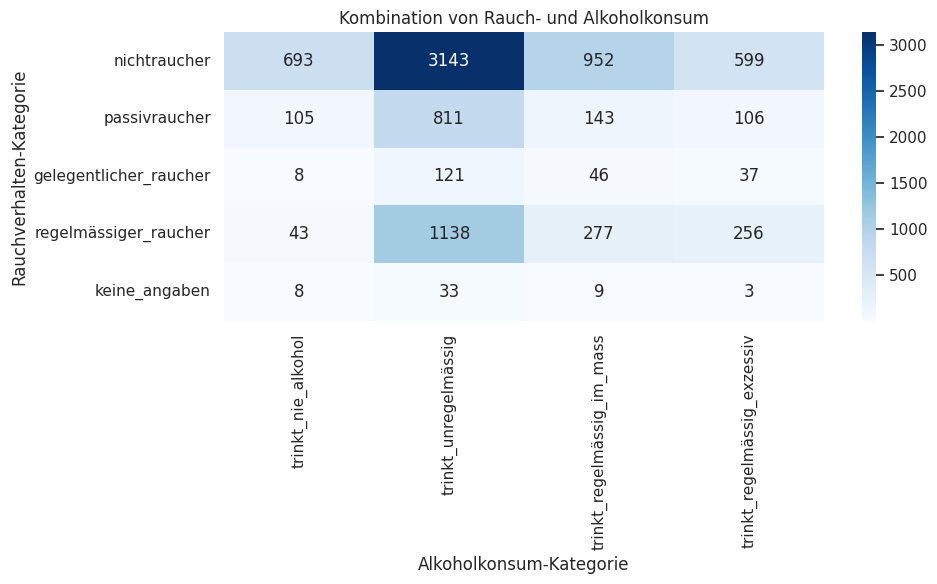

In [47]:
# Falls noch nicht geschehen: Alkoholkonsum in df_fe klassifizieren
def classify_alcohol(row):
    ever_12 = row["ALQ110"]
    freq    = row["ALQ120Q"]
    binge   = row["ALQ151"]

    if ever_12 == 2:
        return "trinkt_nie_alkohol"
    if pd.isna(freq) or freq <= 1:
        return "trinkt_unregelmässig"
    if (not pd.isna(binge) and binge == 1) or freq >= 5:
        return "trinkt_regelmässig_exzessiv"
    return "trinkt_regelmässig_im_mass"

# Direkt auf df_fe anwenden
df_fe["alkoholkonsum_kategorie"] = df_fe.apply(classify_alcohol, axis=1)

# Als kategorische Reihenfolge definieren
cats_alc = [
    "trinkt_nie_alkohol",
    "trinkt_unregelmässig",
    "trinkt_regelmässig_im_mass",
    "trinkt_regelmässig_exzessiv",
    "keine_angabe"
]
df_fe["alkoholkonsum_kategorie"] = pd.Categorical(
    df_fe["alkoholkonsum_kategorie"],
    categories=cats_alc,
    ordered=True
)

# Kreuztabelle erstellen – mit df_fe statt questionnaire
kreuz = pd.crosstab(
    df_fe["rauchverhalten_kategorie"],
    df_fe["alkoholkonsum_kategorie"]
)

# Heatmap darstellen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(kreuz, annot=True, fmt="d", cmap="Blues")
plt.title("Kombination von Rauch- und Alkoholkonsum")
plt.xlabel("Alkoholkonsum-Kategorie")
plt.ylabel("Rauchverhalten-Kategorie")
plt.tight_layout()
plt.show()


***Feature 6 ***

«Food & Finance» haben wir drei NHANES-Variablen zu einem kompakten sozio-ökonomischen Paket zusammengeführt:

Food-Security
Secure, moderate oder severe bestimmen wir aus
• FSD032C (0 = food-secure / 1 = moderate / 2 = severe) sowie
• FSD151 («Erwachsene haben im letzten Jahr gehungert», 1 = Ja).
Ein Wert 2 oder ein Hunger-Erlebnis genügt, um direkt auf severe hochzustufen.

Klassifikationen nach dem USDA-Household Food Security Survey Module, vgl. Bickel et al. 2000.

Einkommens­schicht (PIR-Quintil)
Die INDFMPIR – «poverty-income ratio» (< 1 = unter Armutsgrenze) – teilen wir per pd.qcut in fünf gleich grosse Gruppen Q1_lowest … Q5_highest. Das ist gängige Praxis in CDC-Auswertungen, weil Quintile rasch vergleichbar sind, ohne absolute Dollarbeträge ausweisen zu müssen.

risk_flag
Hier fassen wir medizinische und ökonomische Belastung zusammen:
risk_flag = 1, wenn eine Person Diabetes oder Hypertonie (diagnose_haupt, Feature 2) und gleichzeitig moderate oder severe Food-Insecurity hat. Damit identifizieren wir jene Haushalte, in denen metabolische Erkrankungen und mangelnde Ernährungs­sicherheit kumulieren – ein Fokus, den WHO und BLV seit 2022 ausdrücklich empfehlen (vgl. WHO «Equity and social determinants of health», 2022).

Diese drei Felder erlauben uns später im interaktiven Dashboard, z. B. live zu filtern:
«Zeige nur Q1-Haushalte mit severe Food-Insecurity – wie hoch ist dort die Diabetes­prävalenz?»

So wird der sozio-ökonomische Kontext unmittelbar sichtbar, anstatt in der reinen Gesundheits­statistik

In [77]:
# Feature 6 – Food-Security, Income-Quintil, Gesamt-Risiko
# --------------------------------------------------------------
# Spalten, die NHANES mitliefert:
#   • FSD032C  –  0 = food-secure / 1 = moderate / 2 = severe insecurity
#   • FSD151   –  Erwachsene hungerten im letzten Jahr?  1 = Ja
#   • INDFMPIR –  Poverty-Income-Ratio  (<1 = unter Armuts-grenze)
#
# Ergebnis:
#   • food_security        ('secure' / 'moderate' / 'severe')
#   • pir_quintil          (Q1…Q5 → einfacher Slider im Plot)
#   • risk_flag            (1 = Diabetes oder Hypertonie UND food-insecure)

# 1) Food-Security-Level
def cat_food(row):
    if row["FSD151"] == 1 or row["FSD032C"] == 2:
        return "severe"
    if row["FSD032C"] == 1:
        return "moderate"
    return "secure"

df_fe["food_security"] = df_fe.apply(cat_food, axis=1)

# 2) Poverty-Income-Ratio in Quintile einteilen
df_fe["pir_quintil"] = pd.qcut(
    df_fe["INDFMPIR"],
    q=5,
    labels=["Q1_lowest","Q2","Q3","Q4","Q5_highest"]
)

# 3) Gesamt-Risikoflag: cardiometabolic & food-insecure
df_fe["risk_flag"] = (
    df_fe["diagnose_haupt"].isin(["Diabetes","Bluthochdruck"])
    & df_fe["food_security"].isin(["moderate","severe"])
).astype(int)

print(df_fe[["food_security","pir_quintil","risk_flag"]].head())


  food_security pir_quintil  risk_flag
0        secure          Q2          0
1        secure          Q3          0
2        secure  Q5_highest          0
3        secure          Q4          0
4        secure  Q5_highest          0


**Feature 7 – Ableitung des PAL-Levels**

Für jede Person weisen wir ein PAL-Level (physical activity level) zu, das wir aus der NHANES-Variable PAD615 herleiten. PAD615 gibt an, wie viele Minuten pro Woche die befragte Person mindestens moderat aktiv war.



| PAD615 [min / Woche] | PAL-Level | wissenschaftliche Grundlage |
|---------------------:|-----------|-----------------------------|
| < 150 min | **low** | unter WHO-Mindestempfehlung von 150 min/W (WHO Guideline on Physical Activity 2020) |
| 150 – 300 min | **moderate** | entspricht «normal aktiver Erwachsener», PAL-Faktor ≈ 1.55 (FAO/WHO 2004) |
| > 300 min | **high** | WHO: ≥ 300 min/W bringt Zusatznutzen, PAL ≈ 1.75 |
| *fehlend* | **moderate** | bei fehlenden Angaben empfiehlt WHO den Durchschnitts­wert PAL ≈ 1.55 |


Damit verknüpfen wir objektive Bewegungs­daten mit den Energie­referenzen des BLV: Die BLV-Tabelle, die wir in Block 3 aufgelöst haben, ist nach sex × age × PAL strukturiert. Durch die PAL-Zuordnung bekommt jede Person automatisch den passenden Richtwert für Energie, Fett%, Protein und Natrium – Grundlage für unsere bedarfs-adjustierten Ratios (Feature 8) und das anschliessende Clustering.

In [49]:
# Feature-Block 7 – PAL-Level (low / moderate / high)
# ---------------------------------------------------
# Quelle: PAD615  = Minuten moderater Aktivität pro Woche
#   < 150  → low
#   150–300 → moderate
#   > 300  → high
#   NaN    → moderate   (WHO-Default ≈ PAL 1.55)
# Mit diesem PAL-Label erhält jede Person automatisch die passenden BLV-Richtwerte für Energie, Fett, Protein und Natrium – Grundlage für unsere Ratio-Features und das bedarfs­adjustierte Clustering.
def classify_pal(min_week):
    if pd.isna(min_week):
        return "moderate"       # empfohlenes Default-Niveau (WHO)
    if min_week < 150:
        return "low"
    if min_week <= 300:
        return "moderate"
    return "high"

df_fe["pal_level"] = df_fe["PAD615"].apply(classify_pal)

print(df_fe["pal_level"].value_counts(dropna=False))


pal_level
moderate    7753
low          614
high         164
Name: count, dtype: int64


# Berechnung der Ratio-Features und weicher Ausschluss

**1. Ratio-Berechnung**  
Für jede Person berechnen wir das Verhältnis zwischen gemessener Nährstoffzufuhr und persönlicher BLV-Empfehlung (CH 2022):  

Vier Ratio-Spalten entstehen:  
- `kcal_ratio` (Kalorien)  
- `fat_ratio` (Fett)  
- `protein_ratio` (Protein)  
- `na_ratio` (Natrium)  

**2. Median-Imputation der BLV-Werte**  
Fehlende BLV-Referenzwerte werden innerhalb homogener Gruppen (Geschlecht, Altersjahr, PAL) durch den Median ersetzt, sodass keine Empfehlung mehr fehlt.

**3. Neutrale Füllung**  
Um fehlende Ratios nicht als Überschuss zu werten, füllen wir vor dem Filter alle `NaN` mit **1** (genau dem Empfehlung-Wert).

**4. Weicher Ausschluss (mind. 1 abweichende Ratio)**  
- Personen mit **keiner** abweichenden Ratio (alle Werte = 1) werden entfernt.  
- Vorteil: Wir behalten alle Datensätze, die mindestens einen tatsächlichen Messwert liefern, und verlieren nur solche ohne jegliche Nährstoffmessung.


Fehlende Ratio-Werte gesamt: 13414


<Axes: ylabel='kcal_ratio'>

Text(0.5, 1.0, 'Kalorien')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

<Axes: ylabel='fat_ratio'>

Text(0.5, 1.0, 'Fett')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

<Axes: ylabel='protein_ratio'>

Text(0.5, 1.0, 'Protein')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

<Axes: ylabel='na_ratio'>

Text(0.5, 1.0, 'Natrium')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

Text(0.5, 0.98, 'Abweichung vom persönlichen BLV-Referenzwert')

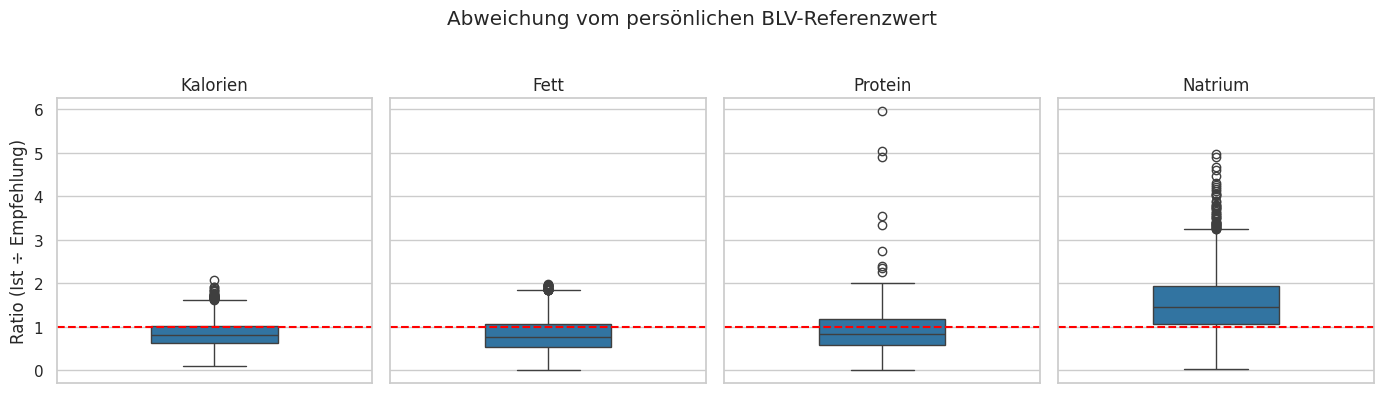

In [78]:
# Feature-Block 8 – BLV-Median-Imputation & Ratio-Boxplots (korrekt gruppiert)
# ----------------------------------------------------------------------------
# Basis: df_imp = df_final (enthält sex, age_years, pal und BLV-Grenzen)
df_imp = df_final.copy()

# Median-Imputation der BLV-Referenzwerte
group_cols = ["sex", "age_years", "pal"]
for ref in ["energy_kcal", "fat_max_g", "protein_max_g", "sodium_max_mg"]:
    med = df_imp.groupby(group_cols)[ref].transform("median")
    df_imp[ref] = df_imp[ref].fillna(med)

# Ratio-Spalten berechnen (Ist ÷ Empfehlung)
df_imp["kcal_ratio"]    = df_imp["DR1TKCAL"]   / df_imp["energy_kcal"]
df_imp["fat_ratio"]     = df_imp["DR1TTFAT"]   / df_imp["fat_max_g"]
df_imp["protein_ratio"] = df_imp["DR1TPROT"]   / df_imp["protein_max_g"]
df_imp["na_ratio"]      = df_imp["DR1TSODI"]   / df_imp["sodium_max_mg"]

# Kontrolle – fehlende Ratio-Werte zählen
print("Fehlende Ratio-Werte gesamt:",
      df_imp[["kcal_ratio","fat_ratio","protein_ratio","na_ratio"]]
        .isna().sum().sum())

# Anschauliche Boxplots je Ratio
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
sns.set_style("whitegrid")

for ax, col, title in zip(
        axes,
        ["kcal_ratio","fat_ratio","protein_ratio","na_ratio"],
        ["Kalorien","Fett","Protein","Natrium"]):

    sns.boxplot(y=df_imp[col], ax=ax, width=0.4)
    ax.axhline(1, ls="--", color="red")  # 1 = Empfehlung
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Ratio (Ist ÷ Empfehlung)")
    ax.set_xticks([])

plt.suptitle("Abweichung vom persönlichen BLV-Referenzwert")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [79]:
# Block 9 – Mehr ein Bereinigungsarbeit aber da basierend auf Feature 8 hier
#Weicher Ausschluss basierend auf Ratio-Features
# ----------------------------------------------------------------------------
# Wir entfernen nur Personen ohne **eine einzige** abweichende Ratio (≠ 1).
# Damit behalten wir alle, die mindestens einen gemessenen Nährstoff haben.

# 1) Neutrale Füllung: alle NaN in den Ratios auf 1 setzen
ratio_cols = ["kcal_ratio", "fat_ratio", "protein_ratio", "na_ratio"]
df_imp[ratio_cols] = df_imp[ratio_cols].fillna(1)

# 2) Anzahl abweichender Ratios pro Person zählen
df_imp["num_valid_ratios"] = (df_imp[ratio_cols] != 1).sum(axis=1)

# 3) Subset mit mindestens 1 abweichender Ratio
df_plot = df_imp[df_imp["num_valid_ratios"] >= 1]

# 4) Kennzahlen ausgeben
n_total = len(df_imp)
n_after  = len(df_plot)

print(f"Teilnehmende insgesamt           : {n_total}")
print(f"Verbleibende nach Ausschluss     : {n_after} ({n_after/n_total*100:.1f} %)")
print(f"Entfernt durch weichen Ausschluss: {n_total-n_after} ({(n_total-n_after)/n_total*100:.1f} %)")

# 5) Verteilung abweichender Ratios pro Person
print("\nAnzahl abweichender Ratios pro Person:")
print(df_imp["num_valid_ratios"].value_counts().sort_index())


Teilnehmende insgesamt           : 6997
Verbleibende nach Ausschluss     : 6996 (100.0 %)
Entfernt durch weichen Ausschluss: 1 (0.0 %)

Anzahl abweichender Ratios pro Person:
num_valid_ratios
0       1
1    4470
3       4
4    2522
Name: count, dtype: int64


# KAQ 1: In welchen Ernährungsgewohnheiten liegt eine potenziell unausgewogene Nährstoffzufuhr vor?



**Erster exoloratives Clustering**
Wir haben die absoluten Tagesmengen (Kilokalorien, Gesamtfett, Eiweiss, Natrium) standardisiert und mit k = 3 via K-Means geclustert.
Die Mittelwerte pro Cluster ergeben folgendes Bild

| Cluster | Kalorien&nbsp;[kcal] | Fett&nbsp;[g] | Eiweiss&nbsp;[g] | Natrium&nbsp;[mg] | Kurz-Interpretation |
|---------|--------------------:|--------------:|-----------------:|------------------:|---------------------|
| **0**   | ≈ 4 100 | 170 | 140 | **6 900** | High-Intake – alles hoch, Natrium extrem |
| **1**   | ≈ 1 300 | 55  |  40 | 2 000 | Low-Intake – eher geringe Zufuhr |
| **2**   | ≈ 2 400 | 85  |  75 | 4 000 | Mittelwert-Gruppe |


KMeans(n_clusters=1, random_state=42)

KMeans(n_clusters=2, random_state=42)

KMeans(n_clusters=3, random_state=42)

KMeans(n_clusters=4, random_state=42)

KMeans(n_clusters=5, random_state=42)

KMeans(n_clusters=6, random_state=42)

KMeans(n_clusters=7, random_state=42)

KMeans(random_state=42)

KMeans(n_clusters=9, random_state=42)

KMeans(n_clusters=10, random_state=42)

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Elbow-Methode zur Bestimmung der Clusteranzahl')

Text(0.5, 0, 'Anzahl Cluster (k)')

Text(0, 0.5, 'WCSS')

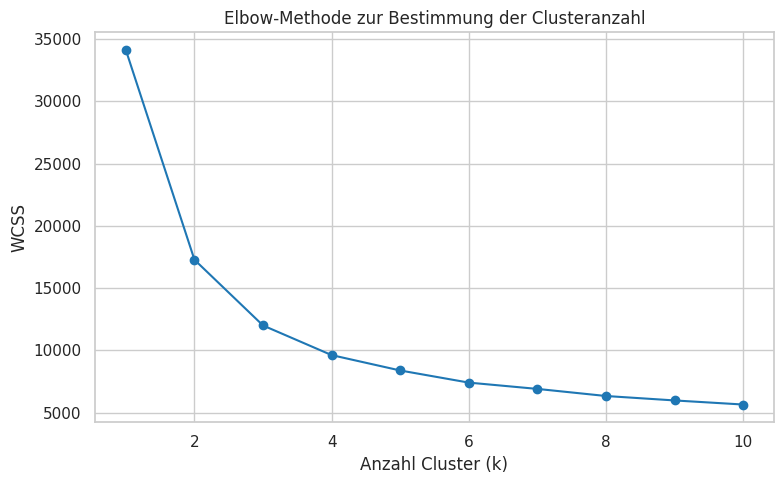

In [80]:
#KAQ1 - Block 1- exploratives Clustering auf Rohdaten

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# STEP 1: Cluster-relevante Spalten extrahieren
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# STEP 2: Daten standardisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# STEP 3: Elbow-Methode zur Bestimmung der optimalen Clusterzahl
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# STEP 4: Plot anzeigen
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow-Methode zur Bestimmung der Clusteranzahl")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
#KAQ 1- exploratives Clusterin auf Rohdaten Block 2
#Prüfen der Qualität bei verschieder Clusteranzahl von 2-10 Clustern (Cluster sind basierend auf standartisierten Rohdaten - nicht Differenzwerten)

from sklearn.preprocessing import StandardScaler

# Wähle die relevanten Features für Clustering
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Finde den besten k-Wert
for k in range(2, 11):  # von 2 bis 10 Cluster
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: Silhouette Score = {score:.3f}")


k=2: Silhouette Score = 0.497
k=3: Silhouette Score = 0.409
k=4: Silhouette Score = 0.353
k=5: Silhouette Score = 0.313
k=6: Silhouette Score = 0.290
k=7: Silhouette Score = 0.277
k=8: Silhouette Score = 0.261
k=9: Silhouette Score = 0.260
k=10: Silhouette Score = 0.247


<Axes: >

Text(0.5, 1.0, 'Durchschnittliche Nährstoffaufnahme pro Cluster (k=3)')

Text(0, 0.5, 'Menge (pro Tag)')

Text(0.5, 0, 'Nährstoff')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Kalorien'),
  Text(1, 0, 'Gesamtfett'),
  Text(2, 0, 'Eiweiss'),
  Text(3, 0, 'Natrium')])

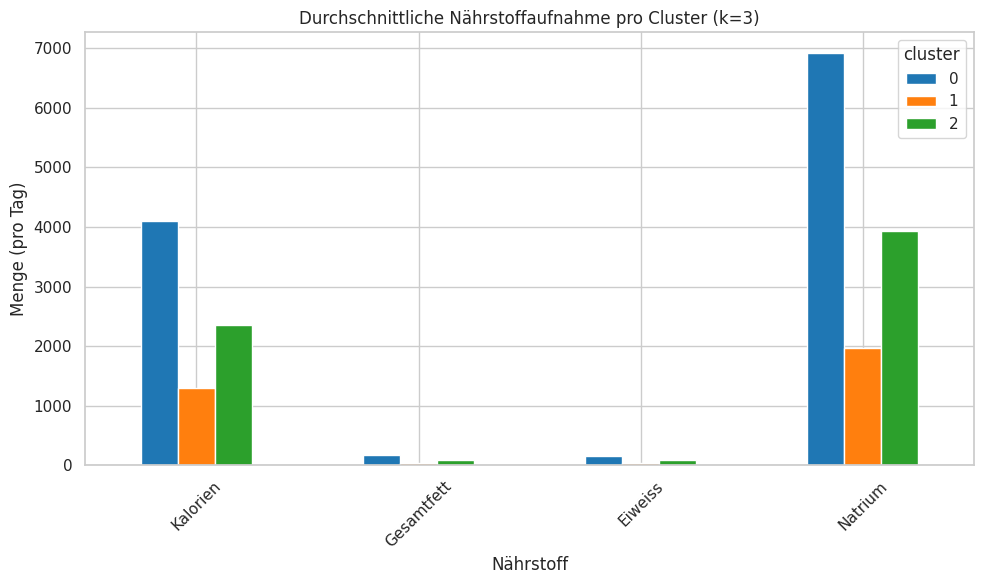

In [82]:
# KAQ 1 - expolratives Clustering auf Rohdaten Block 3
#Interpretation der Cluster k-3

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Cluster erstellen ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# --- Originalnamen zu Klartext umbenennen ---
benennung = {
    'DR1TKCAL': 'Kalorien',
    'DR1TTFAT': 'Gesamtfett',
    'DR1TPROT': 'Eiweiss',
    'DR1TSODI': 'Natrium'
}

# --- Gruppiere nach Cluster und berechne Mittelwerte ---
cluster_bedeutung = df_cluster.groupby('cluster')[cluster_features].mean()
cluster_bedeutung.rename(columns=benennung, inplace=True)

# --- Transponieren für besseres Barplot ---
cluster_bedeutung.T.plot(kind='bar', figsize=(10, 6))
plt.title("Durchschnittliche Nährstoffaufnahme pro Cluster (k=3)")
plt.ylabel("Menge (pro Tag)")
plt.xlabel("Nährstoff")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



**Kurzfazit exploratives Clustering**
Das Verfahren zeigt Muster in den Roh­mengen, aber es sagt nichts darüber aus, ob diese Mengen für die jeweilige Person unausgewogen sind:
Ein 4 100-kcal-Tag kann bei einem Marathonläufer normal sein, bei einer Bürotätigkeit aber klar zu hoch.

Beispiel Cluster 0: Natrium ≈ 7 g klingt «extrem». — Ist aber bei ­Triathleten, die literweise Sportdrink trinken, plausibel.

⇒ reine Mengen-Cluster liefern keine zuverlässige Aussage über «unausgewogene Zufuhr».
Darum wechseln wir im nächsten Schritt auf BLV-normalisierte Ratios und clustern Abweichungen vom persönlichen Referenzwert – erst damit können wir Über- oder Unterversorgung objektiv identifizieren.

In [83]:
#Da Natriumzufuhr trotz Bereinigung sehr hoch wirkt, prüfen wir ob wir sauber bereinigt haben
# 1. Pre-Filter (df_merged aus Block 5)
n_pre = (df_merged["DR1TSODI"] > 12_000).sum()
tot_pre = len(df_merged)

# 2. Post-Filter (df_final)
n_post = (df_final["DR1TSODI"] > 12_000).sum()
tot_post = len(df_final)

print(f"Vor Filter: {n_pre}/{tot_pre} Zeilen > 12 000 mg ({n_pre/tot_pre:.1%})")
print(f"Nach Filter: {n_post}/{tot_post} Zeilen > 12 000 mg ({n_post/tot_post:.1%})")


Vor Filter: 23/8531 Zeilen > 12 000 mg (0.3%)
Nach Filter: 0/6997 Zeilen > 12 000 mg (0.0%)


Vor dem Plausibilitäts-Filter hatten 23 von 8 531 Teilnehmern (0,3 %) eine geschätzte Natrium-Zufuhr von über 12 000 mg pro Tag, nach dem Filter sind es 0 von 6 997 Teilnehmern (0,0 %). Das zeigt:

Absolute Ausreißer (> 12 000 mg) haben wir vollständig eliminiert.

Alle verbleibenden Werte liegen unterhalb dieser toxischen Schwelle – aber das heißt nicht, dass die Natriumzufuhr im Durchschnitt unbedenklich ist.

Tatsächlich belegen mehrere grosse Kohortenstudien, dass schon moderate Überschüsse mit Risiken verbunden sind:

NEJM (2021): Jede Erhöhung der täglichen Natrium-Exkretion um 1 000 mg war mit einer 18 % höheren kardiovaskulären Ereignisrate assoziiert (Hazard Ratio 1,18; 95 % CI 1,08–1,29)
New England Journal of Medicine
.

PURE-Studie (2014): Ein J-förmiger Zusammenhang zwischen natriumexkretion und Mortalität, mit erhöhtem Risiko ab etwa 6 g Natrium pro Tag
Nature
.

Schlussfolgerung: Unsere Bereinigung entfernt nur die extremen Messfehler. Der tatsächliche Überkonsum (z. B. 4 000–8 000 mg pro Tag) bleibt in der NHANES-Population real und muss weiter thematisiert werden – sei es per Ratio-Clustering oder directem Filter auf na_ratio > 1 bzw. > 2.

***Clustern basierend auf Differenzwerte von effektiv konsumiert zu BLV Empfelungen ***

k = 2 WCSS: großer Gewinn, Silhouette: bestmögliche Trennbarkeit. ⇒ trennt die Probanden in Unterversorgung vs. Überversorgung (bezogen auf die BLV-Verhältnisse) sehr klar.

k = 3 Elbow: noch eine deutliche WCSS-Reduktion bis k=3, Silhouette: lässt nur moderat nach (~0.31). ⇒ erzielt zusätzlich eine dritte Gruppe, die sich um 1-fach‐Ratio (≈ ausgewogen) zentriert, während Cluster 0 „Unter­versorgung“ und Cluster 2 „starker Überschuss“ repräsentieren.

KMeans(n_clusters=1, n_init=10, random_state=42)

KMeans(n_clusters=2, n_init=10, random_state=42)

KMeans(n_clusters=3, n_init=10, random_state=42)

KMeans(n_clusters=4, n_init=10, random_state=42)

KMeans(n_clusters=5, n_init=10, random_state=42)

KMeans(n_clusters=6, n_init=10, random_state=42)

KMeans(n_clusters=7, n_init=10, random_state=42)

KMeans(n_init=10, random_state=42)

KMeans(n_clusters=9, n_init=10, random_state=42)

KMeans(n_clusters=10, n_init=10, random_state=42)

<Figure size 600x400 with 0 Axes>

Text(0.5, 1.0, 'Elbow‐Methode (WCSS) für Ratio‐Clustering')

Text(0.5, 0, 'Anzahl Cluster k')

Text(0, 0.5, 'WCSS')

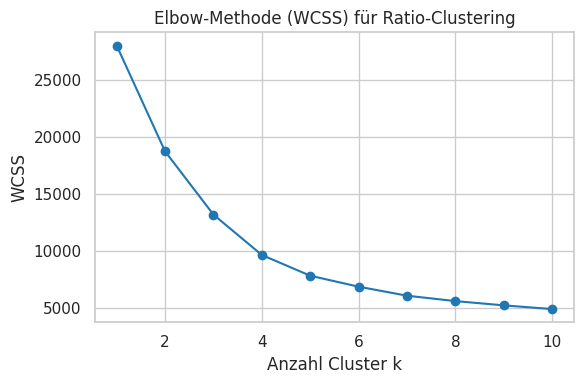

<Figure size 600x400 with 0 Axes>

Text(0.5, 1.0, 'Silhouette‐Score für k=2…10')

Text(0.5, 0, 'Anzahl Cluster k')

Text(0, 0.5, 'Silhouette‐Score')

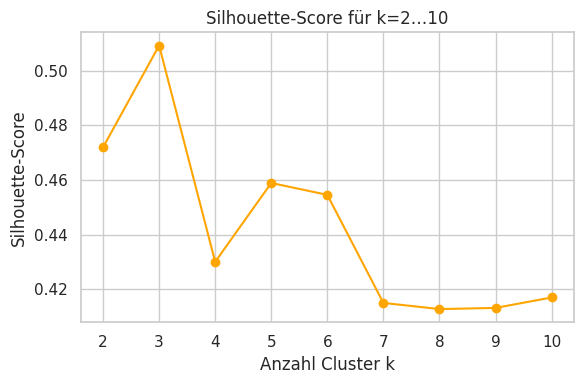

In [84]:
# KAQ1 - clustering auf Basis Differenzwerten - Block1
# Block – Elbow & Silhouette für Ratio‐Features (ohne NaN‐Fehler)
# --------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.metrics       import silhouette_score
import matplotlib.pyplot   as plt

# 1) Ratio‐Spalten aus df_imp (Feature 8) – hier ist df_imp bereits
#    BLV‐imputiert und enthält kcal_ratio, fat_ratio, protein_ratio, na_ratio
ratio_features = ["kcal_ratio", "fat_ratio", "protein_ratio", "na_ratio"]
X_raw = df_imp[ratio_features]

# 2) Fehlende Ratio‐Werte neutral auf 1 setzen (1 = Empfehlung)
X = X_raw.fillna(1)

# 3) Standardisieren (z‐Score)
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Elbow‐Methode (WCSS für k=1…10)
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1,11), wcss, marker='o')
plt.title("Elbow‐Methode (WCSS) für Ratio‐Clustering")
plt.xlabel("Anzahl Cluster k")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Silhouette‐Score (k=2…10)
sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(range(2,11), sil_scores, marker='o', color='orange')
plt.title("Silhouette‐Score für k=2…10")
plt.xlabel("Anzahl Cluster k")
plt.ylabel("Silhouette‐Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
# KAQ1 - clustering auf Basis Differenzwerten - Block2
#  Altersverteilung nach Ernährungs-Balance (k=2)
# ----------------------------------------------------------------
# Wir visualisieren, wie alt die Personen in den beiden Clustern sind,
# und geben zusätzlich Mittel und Median aus.

# 1) Voraussetzungen: df_imp enthält bereits die Spalte 'Balance'
#    mit Werten "Ausgewogen" und "Unausgewogen" und 'RIDAGEYR' (Alter).

import matplotlib.pyplot as plt
import seaborn as sns

# 2) Gruppenstatistiken berechnen
stats = df_imp.groupby('Balance')['RIDAGEYR'] \
    .agg(count='count', mean='mean', median='median') \
    .round(1)
print(stats)

# 3) Boxplot: Altersverteilung je Cluster
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
sns.boxplot(
    x='Balance',
    y='RIDAGEYR',
    data=df_imp,
    palette=['#1f77b4', '#ff7f0e']
)
plt.title('Altersverteilung nach Ernährungs-Balance (k=2)')
plt.xlabel('Ernährungs-Balance')
plt.ylabel('Alter (Jahre)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


KeyError: 'Balance'